<img src="logo.png" width="120">

## Illustration of linear error propagation: ISRF perturbation

This notebook has three main objectives:
+ Present MRD requirement flow-down
+ Illustrate the validity of linear error propagation 
+ Demonstrate the E2ES capability to simulate the effect of perturbed CKD (ISRF) on L2  

The relevant MRD requirement is
<div><img src="MRD-ISRF.png" width="800"/></div>

### 1. Set working enviroment

In [1]:
import sys
import os
import yaml
import numpy as np
from netCDF4 import Dataset
import matplotlib
# define  path to search for module
sys.path.append("/home/raul/Projects/tango/teds/dev")
sys.path.append("/home/raul/builds/teds/venv/lib64/python3.12/site-packages")
os.chdir("/home/raul/tmp/tango-workshop/exp6_isrf")

### 2. Import teds modules

In [2]:
from teds.gm.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.siml1b import simplified_instrument_model_and_l1b_processor
from teds.l1l2.l1bl2 import level1b_to_level2_processor
from teds.lib.libNumTools import get_isrf
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

### 3. Operational flags

In [3]:
proc_gm     = True
proc_sgmgeo = True
proc_sgmrad = True
proc_siml1b = True
proc_l1bl2  = True

pam_acoeff = True
pam_bcoeff = True
pam_req_analysis = True

### 4. GM model

setup for profile = 'individual spectra'. In combination with the simplified L1B processor, this gives us the opertunity to simulate ISRF perturbations as a function of SZA. We provide the input geometry in the cell, however this can be done also in the yaml file.

In [4]:
if(proc_gm):
    #configureation file
    gm_config= yaml.safe_load(open('./settings/gm_config.yaml'))
    gm_config['scene_spec']={}
    gm_config['scene_spec']['sza'] = [70., 60, 50, 40, 30, 20, 10, 0] 
    gm_config['scene_spec']['saa'] = [0.,  0., 0., 0., 0., 0., 0., 0] 
    gm_config['scene_spec']['vza'] = [0.,  0., 0., 0., 0., 0., 0., 0]
    gm_config['scene_spec']['vaa'] = [0.,  0., 0., 0., 0., 0., 0., 0] 
    geometry_module(gm_config)

#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 54e4f26a
Date and timezone       : 2025 February 21 Fri
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.13.2-arch1-1



[16:21:43] Generating detector image timestamps
[16:21:43] Generating geometry for 8 across track locations



###########
# Success #
###########


### 5. SGM-GEO
Similar we do for the SGM. Again, we perfer to provide the surface albedo in the cell below instead of using the yaml file. 

In [5]:
if(proc_sgmgeo):
    sgmgeo_config= yaml.safe_load(open('./settings/sgmgeo_config.yaml'))
    sgmgeo_config['scene_spec'] = {}
    sgmgeo_config['scene_spec']['albedo']= [0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15] 
    geoscene_generation(sgmgeo_config)


###########
# Success #
###########


/home/raul/Projects/tango/teds/dev/teds/gm/vincenty.py:62: RuntimeWarning: invalid value encountered in divide
  cU1 * cU2 * slam / sin_sigma)


#### 6. SGM-RAD

In [6]:
if(proc_sgmrad):
    sgmrad_config= yaml.safe_load(open('./settings/sgmrad_config.yaml'))
    Carbon_radiation_scene_generation(sgmrad_config)

Radiative tranfer simulation...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


###########
# Success #
###########


### 7. Simplified L1B processor

For noise-free simulations, we use the generalized normal distribution as ISRF and vary the configuration parameter `fwhm` and `bcoeff`. Here, `bcoeff` specifies the shape of the ISRF for given `fwhm'. 

In [7]:
if(proc_siml1b):
    # perturbation of the block-shape with constant fwhm
    nbcoeff = 11
    for ib in range(0,nbcoeff):

        siml1b_config= yaml.safe_load(open('./settings/siml1b_config.yaml'))
        siml1b_config['isrf_settings']['type'] =  'generalized_normal' 
        siml1b_config['isrf_settings']['fwhm'] = 0.45
        siml1b_config['isrf_settings']['bcoeff'] = 0.4 + ib*0.01

        str_bcoeff = "%.3f" % (siml1b_config['isrf_settings']['bcoeff'])
        siml1b_config['io_files']['output_l1b'] = 'l1b_bcoeff'+str_bcoeff + '.nc'
        simplified_instrument_model_and_l1b_processor(siml1b_config)

    # perturbation of the fwhm with constant relative shape (block-shape)
    nacoeff = 15
    for ia in range(0,nacoeff):

        siml1b_config= yaml.safe_load(open('./settings/siml1b_config.yaml'))
        siml1b_config['isrf_settings']['type'] =  'generalized_normal' 
        siml1b_config['isrf_settings']['bcoeff'] = 0.45
        siml1b_config['isrf_settings']['fwhm'] = 0.422 + 0.004*ia
 
        str_acoeff = "%.3f" % (siml1b_config['isrf_settings']['fwhm'])
        siml1b_config['io_files']['output_l1b'] = 'l1b_acoeff'+str_acoeff + '.nc'
        simplified_instrument_model_and_l1b_processor(siml1b_config)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 147.24it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 221.16it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 228.42it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 225.31it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 192.15it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 214.82it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 208.74it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 190.30it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 211.44it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 223.59it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 229.41it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 207.24it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 235.01it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 224.05it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 216.06it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 216.39it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 199.08it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 213.54it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 215.81it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 211.15it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 180.16it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 220.28it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 160.36it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 207.01it/s]


=>siml1b calculation finished successfully


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 218.20it/s]

=>siml1b calculation finished successfully


### 8. L2 processing of the $\mathrm{CO_2}$ and $\mathrm{CH_4}$ proxy product

We perform the correspsonding L2 processing:
* First reference simulation with gain simulations
* Loop over different isrf perturbations (acoeff and bcoeff of the generalized normal distribution)

In [8]:
if(proc_l1bl2):

    l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
    l1bl2_config['isrf_settings']['type'] =  'generalized_normal' 
    l1bl2_config['isrf_settings']['fwhm'] = 0.45
    l1bl2_config['isrf_settings']['bcoeff'] = 0.45
    
    nbcoeff = 11
    # perturbation of the block-shape with constant fwhm
    for ib in range(0,nbcoeff):

        bcoeff = 0.4 + ib*0.01
        str_bcoeff = "%.3f" % (bcoeff)

        l1bl2_config['io_files']['input_l1b'] = 'l1b_bcoeff'+str_bcoeff + '.nc'
        l1bl2_config['io_files']['output_l2'] = 'l2_bcoeff'+str_bcoeff + '.nc'
        l1bl2_config['io_files']['output_l2_diag'] = 'l2_diag_bcoeff'+str_bcoeff + '.nc'
            
        level1b_to_level2_processor(l1bl2_config)

    # perturbation of the fwhm with constant relative shape (block-shape)
    nacoeff = 15
    for ia in range(0,nacoeff):

        fwhm = 0.422 + 0.004*ia
        str_acoeff = "%.3f" % (fwhm)
    
        l1bl2_config['io_files']['input_l1b']      = 'l1b_acoeff'+str_acoeff + '.nc'
        l1bl2_config['io_files']['output_l2']      = 'l2_acoeff'+str_acoeff + '.nc'
        l1bl2_config['io_files']['output_l2_diag'] = 'l2_diag_acoeff'+str_acoeff + '.nc'

        level1b_to_level2_processor(l1bl2_config)

level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


l2_bcoeff0.400.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


l2_bcoeff0.410.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


l2_bcoeff0.420.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


l2_bcoeff0.430.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


l2_bcoeff0.440.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


l2_bcoeff0.450.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


l2_bcoeff0.460.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


l2_bcoeff0.470.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


l2_bcoeff0.480.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


l2_bcoeff0.490.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


l2_bcoeff0.500.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


l2_acoeff0.422.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


l2_acoeff0.426.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


l2_acoeff0.430.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


l2_acoeff0.434.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


l2_acoeff0.438.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


l2_acoeff0.442.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


l2_acoeff0.446.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


l2_acoeff0.450.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


l2_acoeff0.454.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


l2_acoeff0.458.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


l2_acoeff0.462.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


l2_acoeff0.466.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


l2_acoeff0.470.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


l2_acoeff0.474.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]

l2_acoeff0.478.nc
diag_output
=> l1bl2 finished successfully


### 9. Data analysis: Sensitivity to fwhm (acoeff)

#### 9.1 Read in data including gains for reference case

In [9]:
# Read level-2 product, calculate the proxy gains from the non-scattering gains, and calculate the 'peturbed' radiances from SGM output. 
# (Could be also extracted from the diag file.)

if(pam_acoeff):

    import netCDF4 as nc
    from copy import deepcopy
    import matplotlib.pyplot as plt

    sza = [70.0, 60, 50, 40, 30, 20, 10, 0]

    nsza = len(sza)
    nacoeff = 15  
    acoeff = np.arange(0, nacoeff)*0.004 + 0.422
    xco2_proxy = np.zeros([nacoeff, nsza])
    xch4_proxy = np.zeros([nacoeff, nsza])
    xco2_ns    = np.zeros([nacoeff, nsza])
    xch4_ns    = np.zeros([nacoeff, nsza])

    prec_xco2_proxy = np.zeros([nacoeff, nsza])
    prec_xco2_ns    = np.zeros([nacoeff, nsza])
    prec_xch4_ns    = np.zeros([nacoeff, nsza])

    for ia in range(nacoeff):    
        str_acoeff = "%.3f" % (acoeff[ia])
        filename = 'l2_acoeff'+str_acoeff+'.nc'
        l2_data = nc.Dataset(filename)
        xco2_proxy[ia,:] = deepcopy(l2_data['XCO2 proxy'][:]).flatten()
        xch4_proxy[ia,:] = deepcopy(l2_data['XCH4 proxy'][:]).flatten()
        xco2_ns[ia,:]    = deepcopy(l2_data['non_scattering_retrieval']['XCO2'][:]).flatten()
        xch4_ns[ia,:]    = deepcopy(l2_data['non_scattering_retrieval']['XCH4'][:]).flatten()
        prec_xco2_proxy[ia,:] = deepcopy(l2_data['precision XCO2 proxy'][:]).flatten()
        prec_xco2_ns[ia,:]    = deepcopy(l2_data['non_scattering_retrieval']['precision XCO2'][:]).flatten()
        prec_xch4_ns[ia,:]    = deepcopy(l2_data['non_scattering_retrieval']['precision XCH4'][:]).flatten()
        l2_data.close()

    filename = 'sgm_atmosphere.nc'
    sgm_data = nc.Dataset(filename)
    albedo = deepcopy(sgm_data['albedo B11'][:])
    xco2_true = deepcopy(sgm_data['XCO2'][:]).flatten()
    xch4_true = deepcopy(sgm_data['XCH4'][:]).flatten()
    sgm_data.close()

    xco2_proxy_error = np.zeros([nacoeff, nsza])
    xch4_proxy_error = np.zeros([nacoeff, nsza])
    xco2_ns_error = np.zeros([nacoeff, nsza])
    xch4_ns_error = np.zeros([nacoeff, nsza])

    for ia in range(nacoeff):
        xco2_proxy_error[ia, :] = (xco2_proxy[ia, :]-xco2_true[:])/xco2_true[:]*100.
        xco2_ns_error[ia, :]    = (xco2_ns[ia, :]-xco2_true[:])/xco2_true[:]*100.
        xch4_ns_error[ia, :]    = (xch4_ns[ia, :]-xch4_true[:])/xch4_true[:]*100.

    # read gains from diag files

    filel2_diag = 'l2_diag_acoeff0.450.nc'
    diag= Dataset(filel2_diag, mode='r')
    gain_ch4_ns    = diag['gain CH4'][:]
    gain_co2_ns    = diag['gain CO2'][:]

    #diag.variables.keys()

    nn, nsza, nwave = gain_co2_ns.shape
    radiance_ref    = np.zeros([nsza, nwave])
    radiance_ref[:,:] = diag['measurement'][:]
    wave_l1b        = diag['wavelength'][0,0,:]
    gain_co2_proxy  = np.zeros([nn,nsza,nwave])
    gain_ch4_proxy  = np.zeros([nn,nsza,nwave])

    # We derive the gain vector for the proxy product from the non-scattering gains. Equation is given in the MRD appendix B.

    for isza in range(nsza):
        gain_co2_proxy[0,isza,:] = (gain_co2_ns[0,isza,:]/xco2_ns[0,isza] - gain_ch4_ns[0,isza,:]/xch4_ns[0,isza])*xco2_proxy[0,isza]
        gain_ch4_proxy[0,isza,:] = (gain_ch4_ns[0,isza,:]/xch4_ns[0,isza] - gain_co2_ns[0,isza,:]/xco2_ns[0,isza])*xch4_proxy[0,isza]

    # simulated perturation of the measurement due to perturbed isrf, i.e., perturbation of the acoeff and bcoeff of 
    # the generalized normal distribution 

    filen_sgmrad = 'sgm_radiance.nc'
    sgmrad = Dataset(filen_sgmrad)
    wave_lbl = sgmrad['wavelength'][:].data
    radiance_per_acoeff = np.zeros([nacoeff,nsza,nwave])

    isrf_config = {}
    isrf_config['type']   = 'generalized_normal' 
    isrf_config['bcoeff'] = 0.45
    for ia in range(nacoeff):
        isrf_config['fwhm'] = 0.422 + 0.004*ia
        isrf_convolution = get_isrf(wave_l1b, wave_lbl, isrf_config)
        for isza in range(nsza):
            radiance_per_acoeff[ia, isza, :] = isrf_convolution(sgmrad['radiance'][0, isza, :].data)

#### 9.2 Plot the induced L2 error (fully iterated) for the fwhm perturbation (a-coefficient) as a function of SZA 

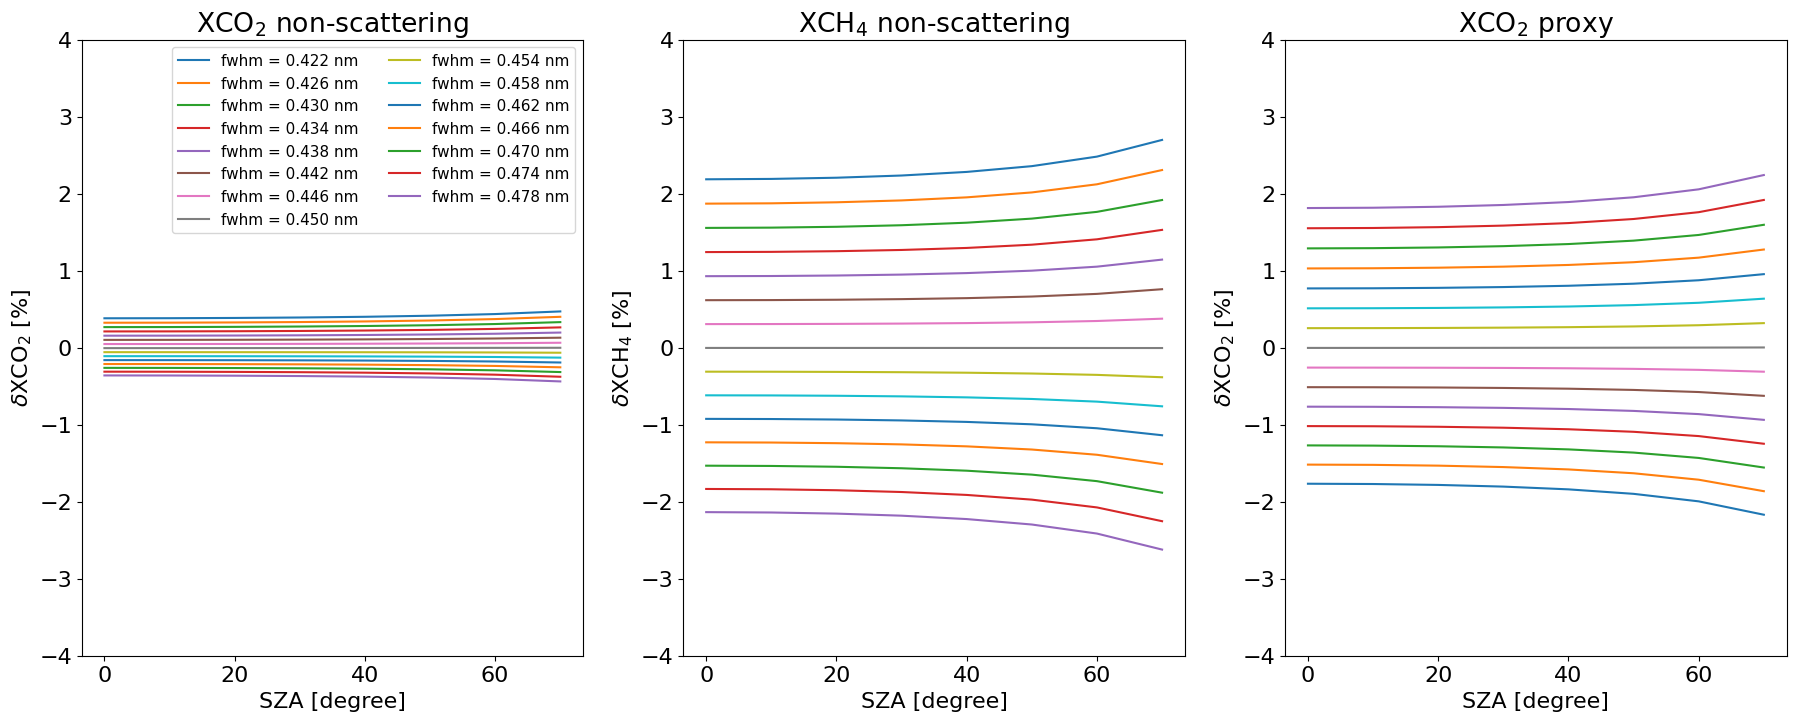

In [10]:
if(pam_acoeff):
    fig = plt.figure(figsize=(22,8), dpi=100,)
    plt.rcParams.update({'font.size': 16})    
    ax1 = fig.add_subplot(131)
        
    for ic in range(15):
        ax1.plot(sza, xco2_ns_error[ic, :], label='fwhm = '+"{:.3f}".format(acoeff[ic])+' nm')
    ax1.set_xlabel('SZA [degree]')
    ax1.set_ylabel('$\\delta$XCO$_2$ [%]')
    ax1.legend(fontsize = '11', ncol = 2)
    ax1.set_ylim([-4., 4.])
    ax1.set_title('XCO$_2$ non-scattering')

    ax2 = fig.add_subplot(132)
    ax2.set_xlabel('SZA [degree]')
    ax2.set_ylabel('$\\delta$XCH$_4$ [%]')
    ax2.set_ylim([-4., 4.])
    ax2.set_title('XCH$_4$ non-scattering')
    for ic in range(15):
        ax2.plot(sza, xch4_ns_error[ic, :], label='b = '+"{:.3f}".format(acoeff[ic]))

    ax3 = fig.add_subplot(133)

    ax3.set_xlabel('SZA [degree]')
    ax3.set_ylabel('$\\delta$XCO$_2$ [%]')
    ax3.set_ylim([-4., 4.])
    ax3.set_title('XCO$_2$ proxy')
    for ic in range(15):
        ax3.plot(sza, xco2_proxy_error[ic, :], label='b = '+"{:.3f}".format(acoeff[ic]))
    plt.savefig('exp6_isrf_sza.png',)

#### What do we see?
Left panel: The true `fwhm` is 0.45 nm. Any perturbation causes an L2 error. For the non-scattering retrieval, we see litle sensitivity. This has to do with the relatively high line density of the CO2 absorption band. 

Middle panel: Same for non-scattering XCH4. The line density for the CH4 bands is much lower making it more sensitive to ISRF perturbation. (color code is the same in all panels)

Right panel:Because of the errors in the non-scattering XCH4, the proxy errors of XCO2 are larger than for the correspsonding non-scattering XCO2 product. 

Remember: 

$ {\mathrm{XCO_2^{proxy}}} = \frac{[\mathrm{[CO_2^{ns}]}}{\mathrm{[CH_4^{ns}]}} \mathrm{XCH_4^{\mathrm{mod}}} $


#### 9.3 Plot the L2 induced error as a function of perturbed fwhm for the itertative solution and for linear error propagation.

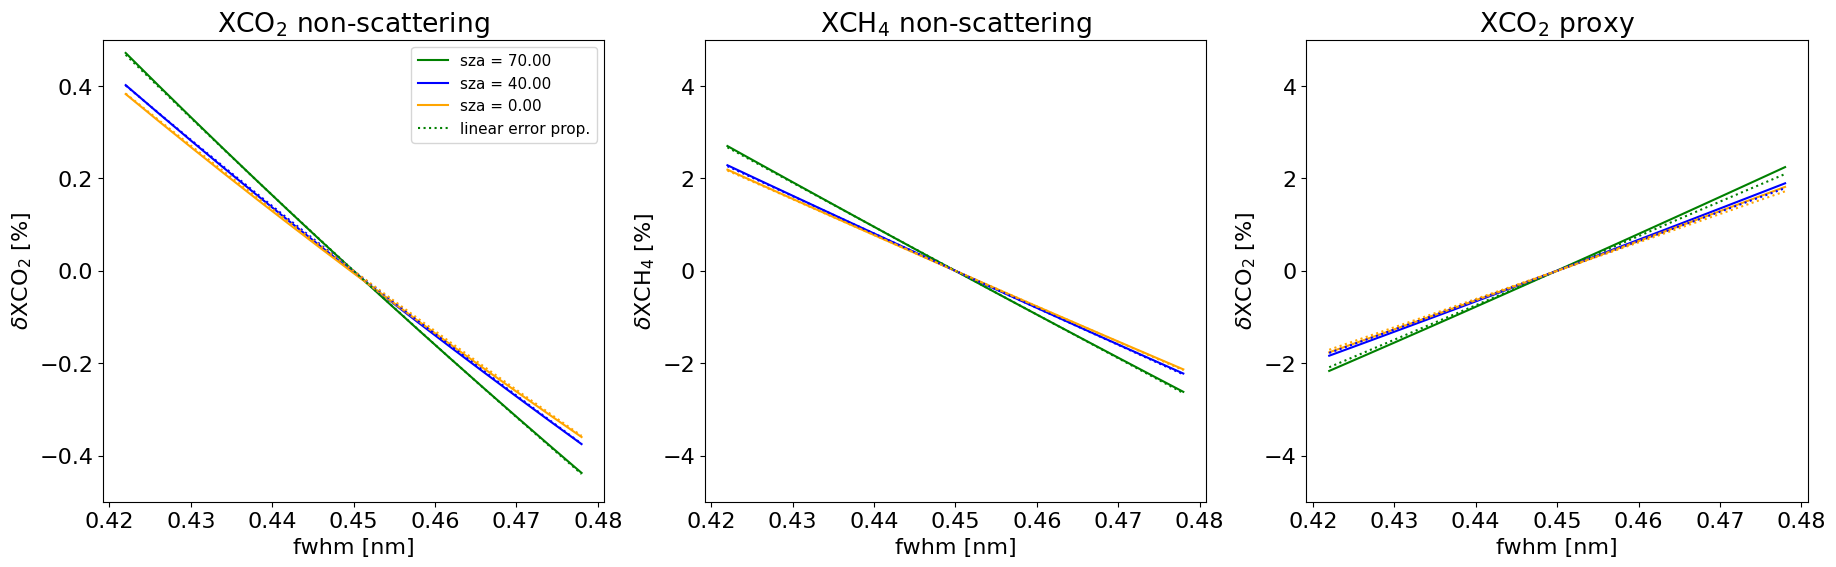

In [11]:
if(pam_acoeff):

    nacoeff,nsza,nwave = radiance_per_acoeff.shape

    delta_XCO2ns    = np.zeros([nacoeff,nsza])
    delta_XCH4ns    = np.zeros([nacoeff,nsza])
    delta_XCO2      = np.zeros([nacoeff,nsza])

    for ia in range(nacoeff):
        for isza in range(nsza):
            deltarad = radiance_per_acoeff[ia,isza,:]-radiance_ref[isza,:]
            delta_XCO2ns[ia,isza] = np.dot(gain_co2_ns[0,isza,:],deltarad)/xco2_true[isza]*100.
            delta_XCH4ns[ia,isza] = np.dot(gain_ch4_ns[0,isza,:],deltarad)/xch4_true[isza]*100.
            delta_XCO2[ia, isza]  = np.dot(gain_co2_proxy[0,isza,:],deltarad)/xco2_true[isza]*100.

    fig = plt.figure(figsize=(22,6), dpi=100,)
    plt.rcParams.update({'font.size': 16})
    
    ax1 = fig.add_subplot(131)

    ax1.plot(acoeff, xco2_ns_error[:, 0], label='sza = '+"{:.2f}".format(sza[0]), color = 'green')
    ax1.plot(acoeff, xco2_ns_error[:, 3], label='sza = '+"{:.2f}".format(sza[3]), color = 'blue')
    ax1.plot(acoeff, xco2_ns_error[:, 7], label='sza = '+"{:.2f}".format(sza[7]), color = 'orange')

    ax1.plot(acoeff, delta_XCO2ns[:, 0], label='linear error prop.',linestyle = ':', color = 'green')
    ax1.plot(acoeff, delta_XCO2ns[:, 3], linestyle = ':', color = 'blue')
    ax1.plot(acoeff, delta_XCO2ns[:, 7], linestyle = ':', color = 'orange')

    ax1.set_xlabel('fwhm [nm]')
    ax1.set_ylabel('$\\delta$XCO$_2$ [%]')
    ax1.legend(fontsize = '11')
    ax1.set_ylim([-0.5, 0.5])
    ax1.set_title('XCO$_2$ non-scattering')
    
    ax2 = fig.add_subplot(132)
    
    ax2.set_xlabel('fwhm [nm]')
    ax2.set_ylabel('$\\delta$XCH$_4$ [%]')
    ax2.set_ylim([-5., 5.])
    ax2.set_title('XCH$_4$ non-scattering')

    ax2.plot(acoeff, xch4_ns_error[:, 0], label='sza = '+"{:.2f}".format(sza[0]), color = 'green')
    ax2.plot(acoeff, xch4_ns_error[:, 3], label='sza = '+"{:.2f}".format(sza[3]), color = 'blue')
    ax2.plot(acoeff, xch4_ns_error[:, 7], label='sza = '+"{:.2f}".format(sza[7]), color = 'orange')

    ax2.plot(acoeff, delta_XCH4ns[:, 0], linestyle = ':', color = 'green')
    ax2.plot(acoeff, delta_XCH4ns[:, 3], linestyle = ':', color = 'blue')
    ax2.plot(acoeff, delta_XCH4ns[:, 7], linestyle = ':', color = 'orange')
    ax3 = fig.add_subplot(133)
    
    ax3.set_xlabel('fwhm [nm]')
    ax3.set_ylabel('$\\delta$XCO$_2$ [%]')
    ax3.set_ylim([-5., 5.])
    ax3.set_title('XCO$_2$ proxy')
    
    ax3.plot(acoeff, xco2_proxy_error[:, 0], label='sza = '+"{:.2f}".format(sza[0]), color = 'green')
    ax3.plot(acoeff, xco2_proxy_error[:, 3], label='sza = '+"{:.2f}".format(sza[3]), color = 'blue')
    ax3.plot(acoeff, xco2_proxy_error[:, 7], label='sza = '+"{:.2f}".format(sza[7]), color = 'orange')

    ax3.plot(acoeff, delta_XCO2[:, 0], label='sza = '+"{:.2f}".format(sza[0]),linestyle = ':', color = 'green')
    ax3.plot(acoeff, delta_XCO2[:, 3], label='sza = '+"{:.2f}".format(sza[3]),linestyle = ':', color = 'blue')
    ax3.plot(acoeff, delta_XCO2[:, 7], label='sza = '+"{:.2f}".format(sza[7]),linestyle = ':', color = 'orange')

    plt.savefig('exp6_isrf_fwhm.png',)

This demonstrates nicely that the perturbation of the fwhm leads to a linear responds in the L2 product. 

### 10. Data analysis: Sensitivity to shape parameter `bcoeff`

#### 10.1 Read data from files

In [12]:
if(pam_bcoeff):

    sza = [70., 60, 50, 40, 30, 20, 10, 0]
    nsza = len(sza)

    nbcoeff = 11
    bcoeff = np.arange(0, nbcoeff)*0.01 + 0.4
                    
    xco2_proxy = np.zeros([nbcoeff, nsza])
    xch4_proxy = np.zeros([nbcoeff, nsza])
    xco2_ns    = np.zeros([nbcoeff, nsza])
    xch4_ns    = np.zeros([nbcoeff, nsza])

    precision_xco2_proxy = np.zeros([nbcoeff, nsza])
    precision_xco2_ns    = np.zeros([nbcoeff, nsza])
    precision_xch4_ns    = np.zeros([nbcoeff, nsza])

    for ib in range(nbcoeff):    

        str_bcoeff = "%.3f" % (bcoeff[ib])
        filename = 'l2_bcoeff'+str_bcoeff+'.nc'
        l2_data = nc.Dataset(filename)

        xco2_proxy[ib, :] = deepcopy(l2_data['XCO2 proxy'][:])
        xch4_proxy[ib, :] = deepcopy(l2_data['XCH4 proxy'][:])

        xco2_ns[ib,:]    = deepcopy(l2_data['non_scattering_retrieval']['XCO2'][:]).flatten()
        xch4_ns[ib,:]    = deepcopy(l2_data['non_scattering_retrieval']['XCH4'][:]).flatten()
        prec_xco2_proxy[ib,:] = deepcopy(l2_data['precision XCO2 proxy'][:]).flatten()
        prec_xco2_ns[ib,:]    = deepcopy(l2_data['non_scattering_retrieval']['precision XCO2'][:]).flatten()
        prec_xch4_ns[ib,:]    = deepcopy(l2_data['non_scattering_retrieval']['precision XCH4'][:]).flatten()
        l2_data.close()

    filename = 'sgm_atmosphere.nc'
    sgm_data = nc.Dataset(filename)
    xco2_true = deepcopy(sgm_data['XCO2'][:]).flatten()
    xch4_true = deepcopy(sgm_data['XCH4'][:]).flatten()
    sgm_data.close()

    xco2_proxy_error = np.zeros([nbcoeff, nsza])
    xch4_proxy_error = np.zeros([nbcoeff, nsza])
    xco2_ns_error = np.zeros([nbcoeff, nsza])
    xch4_ns_error = np.zeros([nbcoeff, nsza])

    for ib in range(nbcoeff):
            xco2_proxy_error[ib, :] = (xco2_proxy[ib, :]-xco2_true[:])/xco2_true[:]*100.
            xch4_proxy_error[ib, :] = (xch4_proxy[ib, :]-xch4_true[:])/xch4_true[:]*100.
            xco2_ns_error[ib, :] = (xco2_ns[ib, :]-xco2_true[:])/xco2_true[:]*100.
            xch4_ns_error[ib, :] = (xch4_ns[ib, :]-xch4_true[:])/xch4_true[:]*100.

    # read gains from diag files

    filel2_diag = 'l2_diag_acoeff0.450.nc'
    diag= Dataset(filel2_diag, mode='r')
    gain_ch4_ns    = diag['gain CH4'][:]
    gain_co2_ns    = diag['gain CO2'][:]
    
    # diag.variables.keys()

    nn, nsza, nwave = gain_co2_ns.shape
    radiance_ref    = np.zeros([nsza, nwave])
    radiance_ref[:,:] = diag['measurement'][:]
    wave_l1b        = diag['wavelength'][0,0,:]
    gain_co2_proxy  = np.zeros([nn,nsza,nwave])
    gain_ch4_proxy  = np.zeros([nn,nsza,nwave])

    for isza in range(nsza):
        gain_co2_proxy[0,isza,:] = (gain_co2_ns[0,isza,:]/xco2_ns[0,isza] - gain_ch4_ns[0,isza,:]/xch4_ns[0,isza])*xco2_proxy[0,isza]
        gain_ch4_proxy[0,isza,:] = (gain_ch4_ns[0,isza,:]/xch4_ns[0,isza] - gain_co2_ns[0,isza,:]/xco2_ns[0,isza])*xch4_proxy[0,isza]

    # simulated perturation of the measurement due to perturbed isrf, i.e., perturbation of the acoeff and bcoeff of 
    # the generalized normal distribution 
    filen_sgmrad = 'sgm_radiance.nc'
    sgmrad = Dataset(filen_sgmrad)
    wave_lbl = sgmrad['wavelength'][:].data
    radiance_per_bcoeff = np.zeros([nbcoeff,nsza,nwave])

    isrf_config = {}
    isrf_config['type']   = 'generalized_normal' 
    isrf_config['fwhm'] = 0.45
    for ib in range(nbcoeff):
        isrf_config['bcoeff'] = 0.4 + ib*0.01
        isrf_convolution = get_isrf(wave_l1b, wave_lbl, isrf_config)
        for isza in range(nsza):
            radiance_per_bcoeff[ib, isza, :] = isrf_convolution(sgmrad['radiance'][0, isza, :].data)

#### 10.2 Plot the induced L2 error (fully iterated) for the perturbation of the ISRF shape (`bcoeff`) as a function of SZA

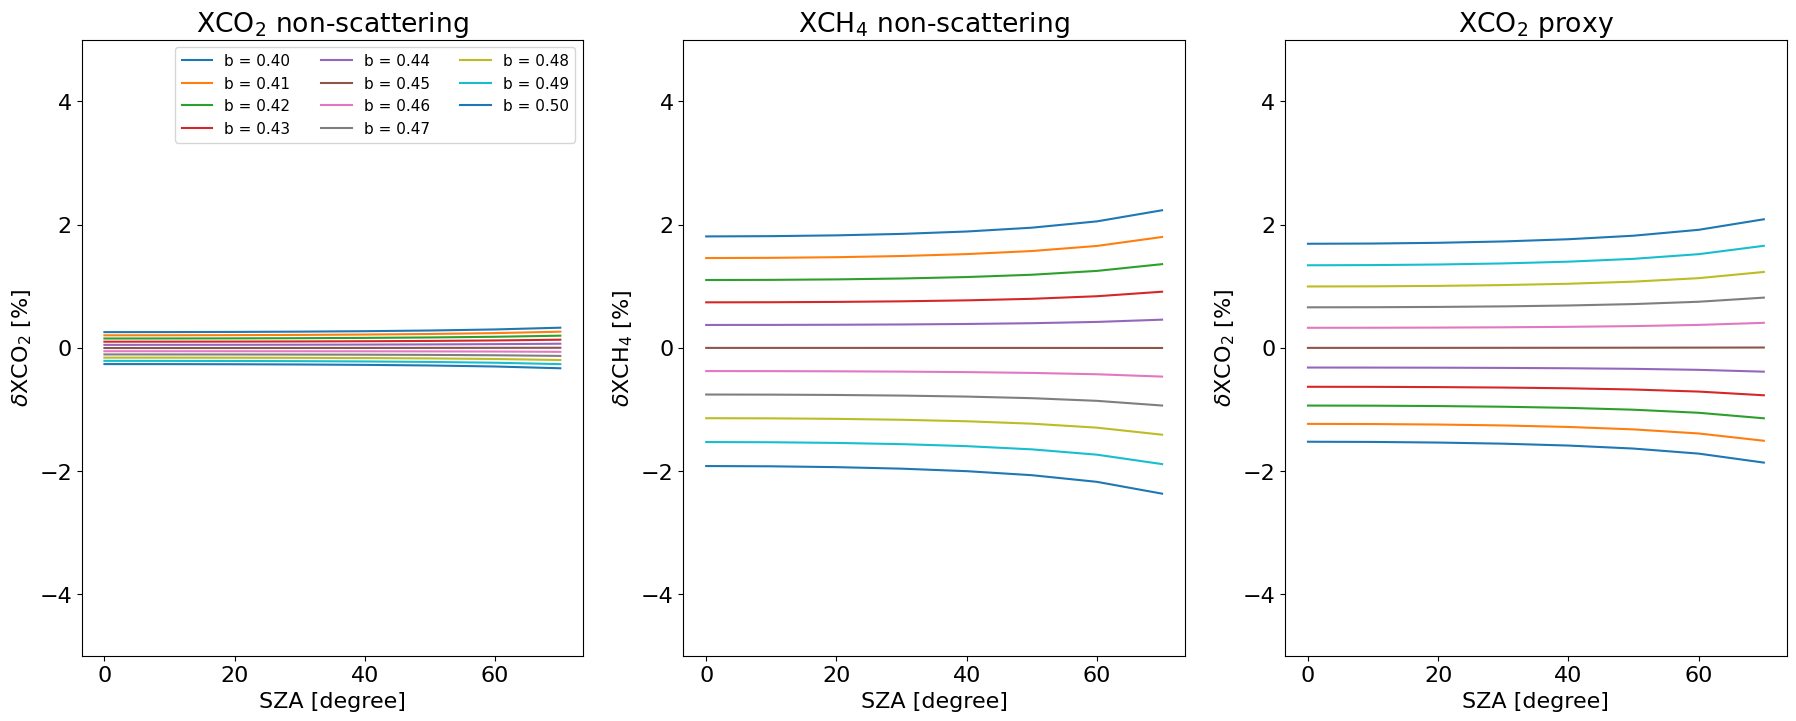

In [13]:
if(pam_bcoeff):
    fig = plt.figure(figsize=(22,8), dpi=100,)
    plt.rcParams.update({'font.size': 16})

    ax1 = fig.add_subplot(131)
    for ib in range(11):
        ax1.plot(sza, xco2_ns_error[ib, :], label='b = '+"{:.2f}".format(bcoeff[ib]))
    ax1.set_xlabel('SZA [degree]')
    ax1.set_ylabel('$\\delta$XCO$_2$ [%]')
    ax1.legend(fontsize = '11', ncol = 3)
    ax1.set_ylim([-5., 5.])
    ax1.set_title('XCO$_2$ non-scattering')

    ax2 = fig.add_subplot(132)

    ax2.set_xlabel('SZA [degree]')
    ax2.set_ylabel('$\\delta$XCH$_4$ [%]')
    ax2.set_ylim([-5., 5.])
    ax2.set_title('XCH$_4$ non-scattering')
    for ib in range(11):
        ax2.plot(sza, xch4_ns_error[ib, :], label='b = '+"{:.2f}".format(bcoeff[ib]))

    ax3 = fig.add_subplot(133)

    ax3.set_xlabel('SZA [degree]')
    ax3.set_ylabel('$\\delta$XCO$_2$ [%]')
    ax3.set_ylim([-5., 5.])
    ax3.set_title('XCO$_2$ proxy')
    for ib in range(11):
        ax3.plot(sza, xco2_proxy_error[ib, :], label='b = '+"{:.2f}".format(bcoeff[ib]))
    plt.savefig('exp6_isrf_bcoeff_sza.png',)

Note: L2 responds is very similar to the purturbation of the fwhm.

#### 10.3 Plot the L2 induced error as a function of perturbed shape parameter `bcoeff` for the itertative solution and for linear error propagation.

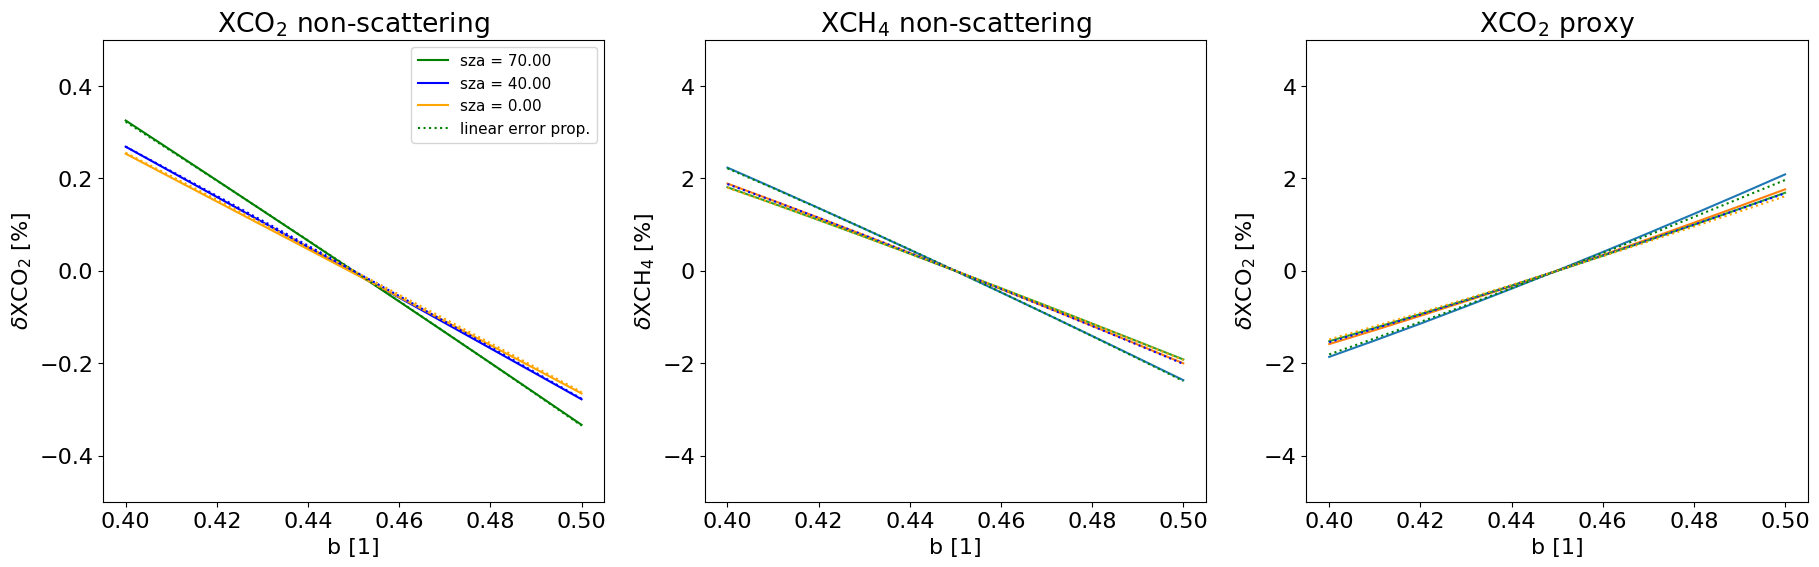

In [14]:
if(pam_bcoeff):

    nbcoeff,nsza,nwave = radiance_per_bcoeff.shape

    delta_XCO2ns    = np.zeros([nbcoeff,nsza])
    delta_XCH4ns    = np.zeros([nbcoeff,nsza])
    delta_XCO2      = np.zeros([nbcoeff,nsza])

    for ib in range(nbcoeff):
        for isza in range(nsza):
            deltarad = radiance_per_bcoeff[ib,isza,:]-radiance_ref[isza,:]
            delta_XCO2ns[ib,isza] = np.dot(gain_co2_ns[0,isza,:],deltarad)/xco2_true[isza]*100.
            delta_XCH4ns[ib,isza] = np.dot(gain_ch4_ns[0,isza,:],deltarad)/xch4_true[isza]*100.
            delta_XCO2[ib, isza]  = np.dot(gain_co2_proxy[0,isza,:],deltarad)/xco2_true[isza]*100.

    fig = plt.figure(figsize=(22,6), dpi=100,)
    plt.rcParams.update({'font.size': 16})
    
    ax1 = fig.add_subplot(131)

    ax1.plot(bcoeff, xco2_ns_error[:, 0], label='sza = '+"{:.2f}".format(sza[0]), color = 'green')
    ax1.plot(bcoeff, xco2_ns_error[:, 3], label='sza = '+"{:.2f}".format(sza[3]), color = 'blue')
    ax1.plot(bcoeff, xco2_ns_error[:, 7], label='sza = '+"{:.2f}".format(sza[7]), color = 'orange')

    ax1.plot(bcoeff, delta_XCO2ns[:, 0], label='linear error prop.',linestyle = ':', color = 'green')
    ax1.plot(bcoeff, delta_XCO2ns[:, 3], linestyle = ':', color = 'blue')
    ax1.plot(bcoeff, delta_XCO2ns[:, 7], linestyle = ':', color = 'orange')

    ax1.set_xlabel('b [1]')
    ax1.set_ylabel('$\\delta$XCO$_2$ [%]')
    ax1.legend(fontsize = '11')
    ax1.set_ylim([-0.5, 0.5])
    ax1.set_title('XCO$_2$ non-scattering')
    
    ax2 = fig.add_subplot(132)
    
    ax2.set_xlabel('b [1]')
    ax2.set_ylabel('$\\delta$XCH$_4$ [%]')
    ax2.set_ylim([-5., 5.])
    ax2.set_title('XCH$_4$ non-scattering')

    ax2.plot(bcoeff, xch4_ns_error[:, 0], label='sza = '+"{:.2f}".format(sza[0]))
    ax2.plot(bcoeff, xch4_ns_error[:, 3], label='sza = '+"{:.2f}".format(sza[3]))
    ax2.plot(bcoeff, xch4_ns_error[:, 7], label='sza = '+"{:.2f}".format(sza[7]))

    ax2.plot(bcoeff, delta_XCH4ns[:, 0], linestyle = ':', color = 'green')
    ax2.plot(bcoeff, delta_XCH4ns[:, 3], linestyle = ':', color = 'blue')
    ax2.plot(bcoeff, delta_XCH4ns[:, 7], linestyle = ':', color = 'orange')
    ax3 = fig.add_subplot(133)
    
    ax3.set_xlabel('b [1]')
    ax3.set_ylabel('$\\delta$XCO$_2$ [%]')
    ax3.set_ylim([-5., 5.])
    ax3.set_title('XCO$_2$ proxy')
    
    ax3.plot(bcoeff, xco2_proxy_error[:, 0], label='sza = '+"{:.2f}".format(sza[0]))
    ax3.plot(bcoeff, xco2_proxy_error[:, 3], label='sza = '+"{:.2f}".format(sza[3]))
    ax3.plot(bcoeff, xco2_proxy_error[:, 7], label='sza = '+"{:.2f}".format(sza[7]))

    ax3.plot(bcoeff, delta_XCO2[:, 0], label='sza = '+"{:.2f}".format(sza[0]),linestyle = ':', color = 'green')
    ax3.plot(bcoeff, delta_XCO2[:, 3], label='sza = '+"{:.2f}".format(sza[3]),linestyle = ':', color = 'blue')
    ax3.plot(bcoeff, delta_XCO2[:, 7], label='sza = '+"{:.2f}".format(sza[7]),linestyle = ':', color = 'orange')

    plt.savefig('exp6_isrf_bcoeff.png',)

Conclusion: Also for the investigated perturbation of the `bcoeff` we see nearly perfect linear response. 

### 11. Analysis L2 error as a function of the ISRF standard deviation
We come to the last topic that is adressed by this notebook. We have seen see a clear sensitivty of the L2 data quality on the ISRF knowledge, better on the knowledge of the fwhm and the `bcoeff` of the ISRF. Also, we found that teh ISRF response of the L2 product is similar for these two parameter. Below, we will show that both dependencies can be combined in a one dependency using the standard deviation $\sigma$ of the ISRF as leading parameter. 

To this end, we will first define the generalized normal distribution as a function. Alternatively, one may use the definition in the linrary libNumTools of TEDS. 

In [15]:
# For generalized normal distribution
import math
def generalized_normal(x, fwhm, b=0.5, deriv=False):
    """Generalized normal distribution.

    :param x: A real value or a numpy array of real values.
    :param float fwhm: Full width at half-maximum.
    :param float b: Shape parameter. Value 0.5 for Gauss, towards 0 for a more
        blocky shape, towards 1 for stronger wings.
    :param bool deriv: If True, give the derivative instead of the
        distribution itself. Default is False.
    :return: Value(s) of generalized normal distribution (or its derivative if
        deriv=True) at `x`, normalized to sum 1 for kernels.
    :rtype: list(float)
    """
    const = np.log(2)**b/(fwhm*math.gamma(1+b))
    y = const*2**(-(2*np.abs(x)/fwhm)**(1/b))
    y /= np.sum(y)
    if deriv:
        y *= -(2/fwhm)**(1/b)*np.log(2)*np.sign(x)*np.abs(x)**(1/b-1)/b
    return y


Next, we read the simulated L2 products from the generated files, we calculate the isrf for the correspsonding parameters `fwhm` and `bcoeff` and determine the isrf standard deviation. 

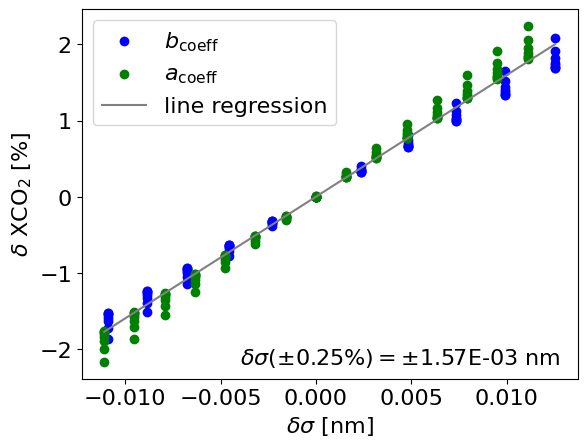

In [16]:
if(pam_req_analysis):

    sza = [70., 60, 50, 40, 30, 20, 10, 0]
    nsza = len(sza)

    nacoeff = 15
    nbcoeff = 11
    bcoeff = np.arange(0, nbcoeff)*0.01 + 0.4
    acoeff = np.arange(0, nacoeff)*0.004 + 0.422
                    
    # The proxy product for perturbations of the acoeff and bcoeff of the ISRF
    bxco2_proxy = np.zeros([nbcoeff, nsza])
    bxch4_proxy = np.zeros([nbcoeff, nsza])
    axco2_proxy = np.zeros([nacoeff, nsza])
    axch4_proxy = np.zeros([nacoeff, nsza])

    # ISRF standard deviation
    bstd = np.zeros([nbcoeff, nsza])
    astd = np.zeros([nacoeff, nsza])
    # generate a wavelength grid for ISRF calculations centered around zero of a width +- 1 nm. 
    # This is needed to calculate the standard deviation of the ISRF 
    wave = (np.arange(2000)-1000)/1000
    nwave = wave.size

    # Get the proxy product from the L2 files
    for ib in range(nbcoeff):    
        acoeff_ref = 0.45
        isrf = generalized_normal(wave, acoeff_ref, bcoeff[ib])
        bstd[ib,:] = np.sqrt(np.power(wave, 2).dot(isrf))
        str_bcoeff = "%.3f" % (bcoeff[ib])
        filename = 'l2_bcoeff'+str_bcoeff+'.nc'
        dataset = nc.Dataset(filename)
        bxco2_proxy[ib, :] = deepcopy(dataset['XCO2 proxy'][:])
        bxch4_proxy[ib, :] = deepcopy(dataset['XCH4 proxy'][:])
        dataset.close()

    for ia in range(nacoeff):    
        bconst_fix = 0.45
        isrf = generalized_normal(wave, acoeff[ia], bconst_fix)
        astd[ia,:] = np.sqrt(np.power(wave, 2).dot(isrf))
        str_acoeff = "%.3f" % (acoeff[ia])
        filename = 'l2_acoeff'+str_acoeff+'.nc'
        dataset = nc.Dataset(filename)
        axco2_proxy[ia, :] = deepcopy(dataset['XCO2 proxy'][:])
        axch4_proxy[ia, :] = deepcopy(dataset['XCH4 proxy'][:])
        dataset.close()

    # Get the ground truth from the SGM
    filename = 'sgm_atmosphere.nc'
    sgm_data = nc.Dataset(filename)
    xco2_true = deepcopy(sgm_data['XCO2'][:]).flatten()
    xch4_true = deepcopy(sgm_data['XCH4'][:]).flatten()
    sgm_data.close()

    #proxy error
    axco2_proxy_error = np.zeros([nacoeff, nsza])
    axch4_proxy_error = np.zeros([nacoeff, nsza])
    bxco2_proxy_error = np.zeros([nbcoeff, nsza])
    bxch4_proxy_error = np.zeros([nbcoeff, nsza])

    for ia in range(nacoeff):
            axco2_proxy_error[ia, :] = (axco2_proxy[ia, :]-xco2_true[:])/xco2_true[:]*100.
            axch4_proxy_error[ia, :] = (axch4_proxy[ia, :]-xch4_true[:])/xch4_true[:]*100.

    for ib in range(nbcoeff):
            bxco2_proxy_error[ib, :] = (bxco2_proxy[ib, :]-xco2_true[:])/xco2_true[:]*100.
            bxch4_proxy_error[ib, :] = (bxch4_proxy[ib, :]-xch4_true[:])/xch4_true[:]*100.

    std_ref = bstd[5,0]
    plt.scatter(bstd.flatten()-std_ref,bxco2_proxy_error.flatten(),label='$b_\\mathrm{coeff}$', color = 'blue')
    plt.scatter(astd.flatten()-std_ref,axco2_proxy_error.flatten(),label='$a_\\mathrm{coeff}$', color = 'green')

    #linear regression through all data points
    std = np.concatenate((astd.flatten(), bstd.flatten(),))
    xco2_error = np.concatenate((axco2_proxy_error.flatten(),bxco2_proxy_error.flatten()))
    std = std - bstd[5,0]
    A = np.vstack([std, np.ones(len(std))]).T
    A = std[:,np.newaxis]
    m, _, _, _ = np.linalg.lstsq(A, xco2_error)
    plt.plot(std, m*std, label='line regression', color='grey')

    #assume an CO2 proxy error of 0.25 %. Calculate the correspsonding std dev error that is acceptable
    e_max = (0.25)/m 
    plt.text(-0.004,-2.2,'$\\delta\\sigma(\\pm 0.25\\%) = \\pm $'+"%.2E" % (e_max[0]) + ' nm')
    plt.legend()
    plt.xlabel('$\\delta \\sigma$ [nm]')
    plt.ylabel('$\\delta$ XCO$_2$ [%]')
    plt.savefig('exp6_isrf_std_dev.png',)

Note: The ISRF induced error using a generalized normal distribtion as ISRF can be described well by the standard deviation of the ISRF.

### Conclusions:

* We should that the E2ES can be used to analyse ISRF induced errors in the L2 product. Thus, it can be used to flowdown requirements on specific ISRF requirements for the SRD.
* We have derived the flow down of L2 requirements to ISRF requirements as formulated in the MRD.
* We illustrated the validity of linear error propagation of ISRF induced errors. Although ISRF errors are not included in the ESRA, it is an important conclusion as it allows to formulate an ISRF requirement independently on other perturbations.
* MRD-L1B-0060 satisfied.